7.5.4: 
Duplicate the results reported in §7.4.
Vary the parameters in the equations and the number of vectors stored by Broyden’s method and report on their effects on performance. What happens in the differential equation examples if preconditioning is omitted?

In [226]:
%matplotlib inline 
import matplotlib.pyplot as plt

from IPython.display import Image

from pylab import rcParams
rcParams['figure.figsize'] = 16, 5

In [227]:
from abc import ABC, abstractmethod

class AbstractOperator(ABC):
    
    def __init__(self):
        super().__init__()
        
    @abstractmethod    
    def __call__(self, x):
        pass

<img src="broyden.png" width="75%" align="center"/>

In [228]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
import math

def brsol(x, F, atol = 10e-6, rtol = 10e-6, maxit = 1000, nmax = 10):
    n = -1
    itc = 0
    
    fx = F(x)
    r0 = np.linalg.norm(fx) / math.sqrt(len(x))
    s0 = -fx
    
    sa = []
    
    sa.append(s0)
    
    itcv = []
    resv = []
    
    itcv.append(itc)
    resv.append(1.0)
    
    while itc < maxit:
        n = n + 1
        itc = itc + 1
        x = x + sa[n]
        fx = F(x)
        nfx = np.linalg.norm(fx) / math.sqrt(len(x))
        
        itcv.append(itc)
        resv.append(nfx / r0)
        
        if nfx <= (rtol * r0 + atol):
            break
        if n < nmax - 1:
            z = -fx
            for j in range(n):
                z = z + sa[j + 1] * (sa[j].dot(z)) / math.pow(np.linalg.norm(sa[j]), 2)
            snp1 = z / (1.0 - sa[n].dot(z) / math.pow(np.linalg.norm(sa[n]), 2))
            sa.append(snp1)
        elif n == nmax - 1:
            n = -1
            sa = []
            s0 = -fx
            sa.append(s0)
    
    return x, itcv, resv
    

<img src="filler.png" width="15%" align="center"/>

$$
(Lu)(x, y) = -(u_{xx}(x, y) + u_{yy}(x, y)) + a_1(x, y)u_x(x, y) + a_2(x, y)u_y(x, y) + a_3u(x, y) = f(x, y)
$$

$$
a_1 = 1,~~~a_2 = 20y,~~~a_3 = 1
$$

$$
h = 1~/~32,~~~\tau_a = \tau_r = h^2
$$

$$
u_0 = 0
$$

$$
u_{exact} = 10xy(1-x)(1-y)exp(x^{4.5})
$$

$$
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
$$

In [229]:
from scipy.fftpack import dst, idst

class PDE_2D_LinearOperator(AbstractOperator):
    
    def __init__(self, N, exact = None):
        self.N   = N
        self.h   = 1.0 / (N + 1)
        self.ih2 = 1.0 / (self.h * self.h)
        self.i2h = 1.0 / (self.h * 2.0)
        self._rhs = np.ones(self.N * self.N)
        if exact is not None:
            ev = np.empty((self.N, self.N))
            for i in range(self.N):
                for j in range(self.N):
                    ev[i][j] = exact((i + 1) * h, (j + 1) * h)
            self._rhs = self.matvec(ev)
            self._exact = ev.reshape(self.N * self.N)
    
    def matvec(self, x):
        
        rx = x.reshape((self.N, self.N))
        nx = np.empty((self.N, self.N))
        
        for i in range(self.N):
            for j in range(self.N):
                nx[i][j] = -self._uxx(rx, i, j) - self._uyy(rx, i, j) + self._a1(rx, i, j) * self._ux(rx, i, j) + self._a2(rx, i, j) * self._uy(rx, i, j) + self._a3(rx, i, j) * self._u(rx, i, j)
        
        return nx.reshape(self.N * self.N)
    
    def rhs(self):
        return self._rhs
    
    def exact(self):
        return self._exact
    
    def __call__(self, x, M = None):
        return self.matvec(x) - self.rhs()
    
    def _uxx(self, v, i, j):
        uip1j = v[i + 1][j] if i < self.N - 1 else 0.0
        uim1j = v[i - 1][j] if i > 0 else 0.0
        return (uip1j - 2.0 * v[i][j] + uim1j) * self.ih2
    
    def _uyy(self, v, i, j):
        uijp1 = v[i][j + 1] if j < self.N - 1 else 0.0
        uijm1 = v[i][j - 1] if j > 0 else 0.0
        return (uijp1 - 2.0 * v[i][j] + uijm1) * self.ih2
    
    def _ux(self, v, i, j):
        uip1j = v[i + 1][j] if i < self.N - 1 else 0.0
        uim1j = v[i - 1][j] if i > 0 else 0.0
        return (uip1j - uim1j) * self.i2h
    
    def _uy(self, v, i, j):
        uijp1 = v[i][j + 1] if j < self.N - 1 else 0.0
        uijm1 = v[i][j - 1] if j > 0 else 0.0
        return (uijp1 - uijm1) * self.i2h
    
    def _u(self, v, i, j):
        return v[i][j]
    
    def _a1(self, v, i, j):
        return 1.0
    
    def _a2(self, v, i, j):
        return 20 * (j + 1) * self.h
    
    def _a3(self, v, i, j):
        return 1.0
        

class Fish2DLinearOperator(AbstractOperator):
    
    def __init__(self, N):
        self.N   = N
        self.h   = 1.0 / (N + 1)
        
    def matvec(self, x):
        x_t = dst(x.reshape((self.N, self.N)), type=1, axis=0, norm='ortho')
        x_t = dst(x_t, type=1, axis=1, norm='ortho')
        
        for i in range(self.N):
            for j in range(self.N):
                n = 4.0 * (np.sin(np.pi * (i + 1) / (2.0 * (N + 1)))) ** 2 + 4.0 * (np.sin(np.pi * (j + 1) / (2.0 * (N + 1)))) ** 2
                n /= self.h ** 2
                x_t[i][j] /= n
        
        invx_t = idst(x_t, type=1, axis=1, norm='ortho')
        invx_t = idst(invx_t, type=1, axis=0, norm='ortho')
        return invx_t.reshape(self.N * self.N)

    def __call__(self, x):
        return self.matvec(x)

class ScipyIterationStorage(object):
    def __init__(self):
        self.rkv = []
        self.itv = []
        self.nit = 0
        
    def __call__(self, rk):
        self.rkv.append(rk)
        self.itv.append(self.nit)
        self.nit += 1

In [230]:
from scipy.sparse.linalg import gmres
import math

def exact(x, y):
    return 10.0 * x * y * (1 - x) * (1 - y) * math.exp(x ** 4.5)


# Problem configuration
N = 31
h = 1.0 / (N + 1)
tol = h * h

# Initial vector
x0 = np.ones(N * N)

pde = PDE_2D_LinearOperator(N, exact = exact)
fish2d = Fish2DLinearOperator(N)

# Linearized operators
pdel = LinearOperator((N * N, N * N), lambda x: pde.matvec(x))
fish2dl = LinearOperator((N * N, N * N), lambda x: fish2d(x))

# Standart gmres with no restarts
gmresinfo = ScipyIterationStorage()
gmresx, success = gmres(pdel, pde.rhs(), M = fish2dl, restart = 100000, tol = tol, callback = gmresinfo)

gmresinfor = ScipyIterationStorage()
gmresxr, successr = gmres(pdel, pde.rhs(), M = fish2dl, restart = 3, tol = tol, callback = gmresinfor)

In [231]:
x0 = np.ones(N * N)

pdewithfish2d = lambda x: fish2d(pde(x))

xar, itcvr, resvr = brsol(x0, pdewithfish2d, atol=tol, rtol=tol, nmax = 3, maxit = 200)
xa, itcv, resv = brsol(x0, pdewithfish2d, atol=tol, rtol=tol, nmax = 3000, maxit = 200)

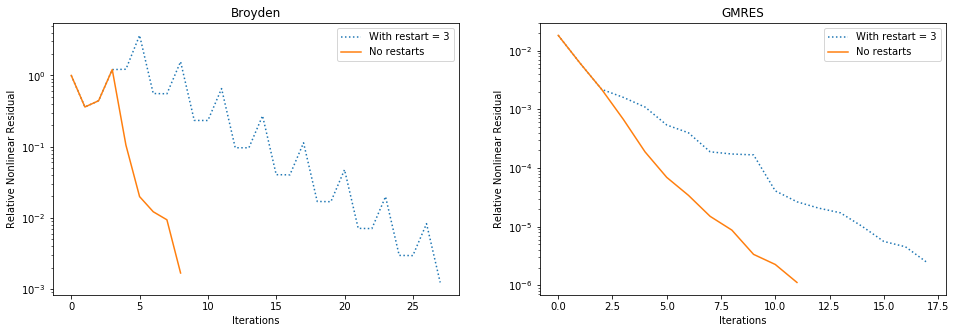

In [232]:
plt.title('Broyden vs GMRES on PDE')

plt.subplot(1, 2, 1)
plt.title('Broyden')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 3')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('GMRES')
plt.plot(gmresinfor.itv, gmresinfor.rkv, linestyle=':', label = 'With restart = 3')
plt.plot(gmresinfo.itv, gmresinfo.rkv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

plt.show()

Vary the parameters in the equations and the number of vectors stored by Broyden's method and report on their effects on performance

/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


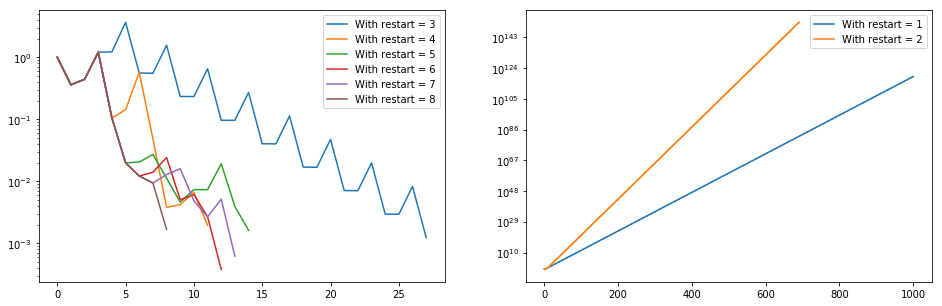

In [258]:
# Problem configuration
N = 31
h = 1.0 / (N + 1)
tol = h * h

plt.subplot(1, 2, 1)

for i in range(3, 9):
    x0 = np.ones(N * N)
    rxa, ritcv, rresv = brsol(x0, pdewithfish2d, atol = tol, rtol = tol, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()

plt.subplot(1, 2, 2)
for i in range(1, 3):
    x0 = np.ones(N * N)
    rxa, ritcv, rresv = brsol(x0, pdewithfish2d, atol = tol, rtol = tol, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()
    
plt.show()

What happens in the differential equation examples if preconditioner is ommited?
Spoiler: nothing good

In [260]:
# Problem configuration
N = 31
h = 1.0 / (N + 1)
tol = h * h

# Initial vector
x0 = np.ones(N * N)

pde = PDE_2D_LinearOperator(N, exact = exact)

xar, itcvr, resvr = brsol(x0, pde, atol=tol, rtol=tol, nmax = 3, maxit = 200)
xa, itcv, resv = brsol(x0, pde, atol=tol, rtol=tol, nmax = 3000, maxit = 200)

# Linearized operators
pdel = LinearOperator((N * N, N * N), lambda x: pde.matvec(x))

# Standart gmres with no restarts
gmresinfo = ScipyIterationStorage()
gmresx, success = gmres(pdel, pde.rhs(), restart = 100000, tol = tol, callback = gmresinfo)

gmresinfor = ScipyIterationStorage()
gmresxr, successr = gmres(pdel, pde.rhs(), restart = 3, tol = tol, callback = gmresinfor)

/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


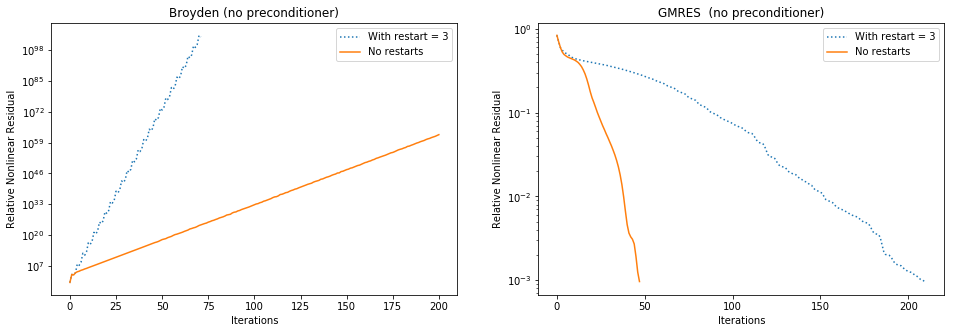

In [263]:
plt.subplot(1, 2, 1)
plt.title('Broyden (no preconditioner)')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 3')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('GMRES  (no preconditioner)')
plt.plot(gmresinfor.itv, gmresinfor.rkv, linestyle=':', label = 'With restart = 3')
plt.plot(gmresinfo.itv, gmresinfo.rkv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

plt.show()

<img src="filler.png" width="15%" align="center"/>

<img src="heq.png" width="75%" align="center"/>

In [233]:
class HEquationNonLinearOperator(AbstractOperator):
    def __init__(self, c):
        super().__init__()
        self.c = c
    
    def __call__(self, x):
        N = len(x)
        out = np.zeros(N)
        
        for i in range(N):
            integral = 0.0
            mi = (i + 1.0 / 2.0) / N
            for j in range(N):
                mj = (j + 1.0 / 2.0) / N
                integral += ((x[j] * mi) / (mi + mj))
            out[i] = x[i] - 1.0 / (1.0 - (self.c / (2.0 * N)) * integral)
        
        return out
                       

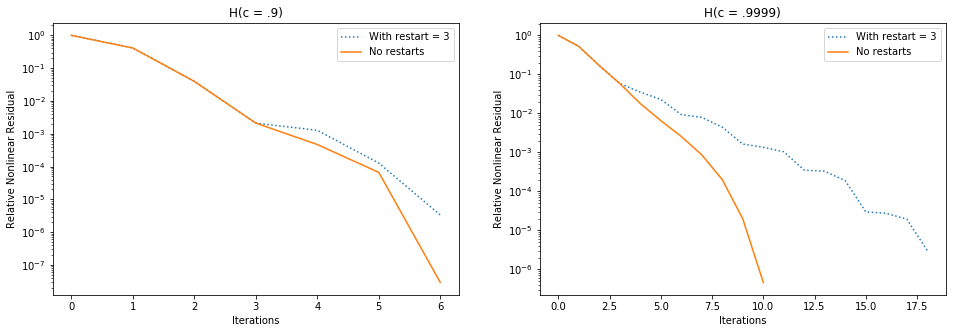

In [234]:
H9 = HEquationNonLinearOperator(c = .9)
H9999 = HEquationNonLinearOperator(c = .9999)

x0 = np.ones(100)

# First plot with H(c = .9)
plt.subplot(1, 2, 1)
xar, itcvr, resvr = brsol(x0, H9, atol=1e-6, rtol=1e-6, nmax = 3)
xa, itcv, resv = brsol(x0, H9, atol=1e-6, rtol=1e-6, nmax = 3000)

plt.title('H(c = .9)')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 3')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

# Second plot with H(c = .9999)
plt.subplot(1, 2, 2)
xar, itcvr, resvr = brsol(x0, H9999, atol=1e-6, rtol=1e-6, nmax = 3)
xa, itcv, resv = brsol(x0, H9999, atol=1e-6, rtol=1e-6, nmax = 3000)

plt.title('H(c = .9999)')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 3')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()

plt.show()

Vary the parameters in the equations and the number of vectors stored by Broyden's method and report on their effects on performance

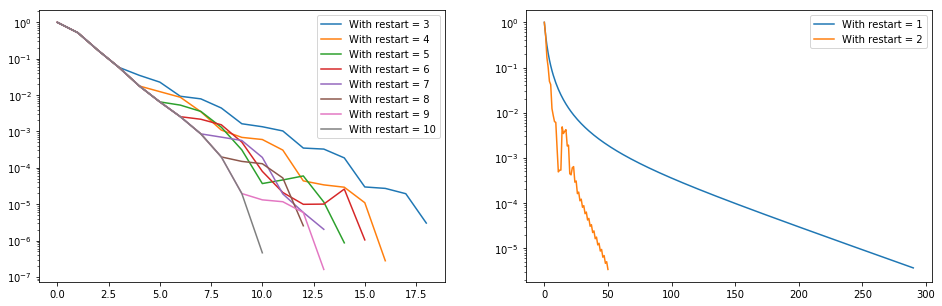

In [252]:
plt.subplot(1, 2, 1)

for i in range(3, 11):
    x0 = np.ones(100)
    problem = HEquationNonLinearOperator(c = .9999)
    rxa, ritcv, rresv = brsol(x0, problem, atol = 1e-6, rtol = 1e-6, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()

plt.subplot(1, 2, 2)
for i in range(1, 3):
    x0 = np.ones(100)
    problem = HEquationNonLinearOperator(c = .9999)
    rxa, ritcv, rresv = brsol(x0, problem, atol = 1e-6, rtol = 1e-6, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()
    
plt.show()

<img src="filler.png" width="15%" align="center"/>

<img src="convdiff.png" width="75%" align="center"/>

$$ -\nabla^2u + Cu(u_x + u_y) = f  $$

In [623]:
class ConvectionDiffusionOperator(AbstractOperator):
    
    def __init__(self, N, C = 20.0, exact = None):
        self.N   = N
        self.h   = 1.0 / (N + 1)
        self.ih2 = 1.0 / (self.h * self.h)
        self.i2h = 1.0 / (self.h * 2.0)
        self.C   = C
        
        self._rhs = np.ones(self.N * self.N)
        if exact is not None:
            ev = np.empty((self.N, self.N))
            for i in range(self.N):
                for j in range(self.N):
                    ev[i][j] = exact((i + 1) * h, (j + 1) * h)
            self._rhs = self.matvec(ev)
            self._exact = ev.reshape(self.N * self.N)
    
    def matvec(self, x):
        
        rx = x.reshape((self.N, self.N))
        nx = np.empty((self.N, self.N))
        
        for i in range(self.N):
            for j in range(self.N):
                nx[i][j] = -self._uxx(rx, i, j) - self._uyy(rx, i, j) + self.C * self._u(rx, i, j) * (self._ux(rx, i ,j) + self._uy(rx, i, j))
        
        return nx.reshape(self.N * self.N)
    
    def matvecf(self, x):
        
        rx = x.reshape((self.N, self.N))
        nx = np.empty((self.N, self.N))
        
        for i in range(self.N):
            for j in range(self.N):
                uip1j = rx[i + 1][j] if i < self.N - 1 else 0.0
                uim1j = rx[i - 1][j] if i > 0 else 0.0
                uijp1 = rx[i][j + 1] if j < self.N - 1 else 0.0
                uijm1 = rx[i][j - 1] if j > 0 else 0.0
                
                uip1puim1 = uip1j + uijp1
                ujp1pujm1 = uijm1 + uim1j
                uij = rx[i][j]
                
                nx[i][j] = -1.0 * self.ih2 * (uip1puim1 + ujp1pujm1 - 4.0 * uij) + self.C * uij * (uip1puim1 - ujp1pujm1) * self.i2h
                
                
        return nx.reshape(self.N * self.N)
    
    def rhs(self):
        return self._rhs
    
    def exact(self):
        return self._exact
    
    def __call__(self, x, M = None):
        return self.matvecf(x) - self.rhs()
    
    def _uxx(self, v, i, j):
        uip1j = v[i + 1][j] if i < self.N - 1 else 0.0
        uim1j = v[i - 1][j] if i > 0 else 0.0
        return (uip1j - 2.0 * v[i][j] + uim1j) * self.ih2
    
    def _uyy(self, v, i, j):
        uijp1 = v[i][j + 1] if j < self.N - 1 else 0.0
        uijm1 = v[i][j - 1] if j > 0 else 0.0
        return (uijp1 - 2.0 * v[i][j] + uijm1) * self.ih2
    
    def _ux(self, v, i, j):
        uip1j = v[i + 1][j] if i < self.N - 1 else 0.0
        uim1j = v[i - 1][j] if i > 0 else 0.0
        return (uip1j - uim1j) * self.i2h
    
    def _uy(self, v, i, j):
        uijp1 = v[i][j + 1] if j < self.N - 1 else 0.0
        uijm1 = v[i][j - 1] if j > 0 else 0.0
        return (uijp1 - uijm1) * self.i2h
    
    def _u(self, v, i, j):
        return v[i][j]

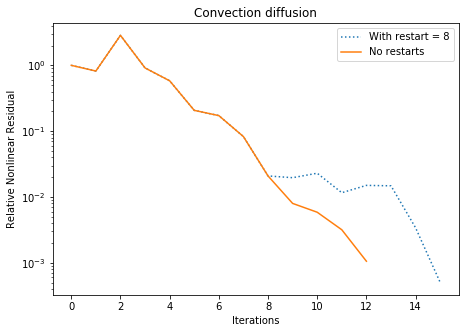

In [624]:
# Problem configuration

N = 31
h = 1.0/ (N + 1)
tol = h * h

x0 = np.zeros(N * N)

cdiff = ConvectionDiffusionOperator(N, exact = exact)
fish2d = Fish2DLinearOperator(N)

problem = lambda x: fish2d(cdiff(x))

xar, itcvr, resvr = brsol(x0, problem, atol=tol, rtol=tol, nmax = 8)
xa, itcv, resv = brsol(x0, problem, atol=tol, rtol=tol, nmax = 3000)

plt.subplot(1, 2, 1)
plt.title('Convection diffusion')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 8')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()
plt.show()

Vary the parameters in the equations and the number of vectors stored by Broyden's method and report on their effects on performance

/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


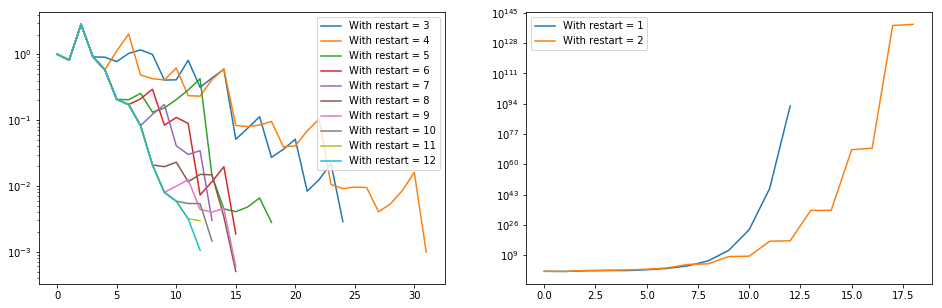

In [267]:
# Problem configuration

N = 31
h = 1.0/ (N + 1)
tol = h * h

x0 = np.zeros(N * N)

cdiff = ConvectionDiffusionOperator(N, exact = exact)
fish2d = Fish2DLinearOperator(N)

problem = lambda x: fish2d(cdiff(x))

plt.subplot(1, 2, 1)

for i in range(3, 13):
    x0 = np.zeros(N * N)
    rxa, ritcv, rresv = brsol(x0, problem, atol = tol, rtol = tol, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()

plt.subplot(1, 2, 2)
for i in range(1, 3):
    x0 = np.zeros(N * N)
    rxa, ritcv, rresv = brsol(x0, problem, atol = tol, rtol = tol, nmax = i)
    plt.plot(ritcv, rresv, label = 'With restart = ' + str(i))
    plt.yscale('log')
    plt.legend()
    
plt.show()

What happens in the differential equation examples if preconditioner is ommited?

/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
/Users/bvdmitri/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


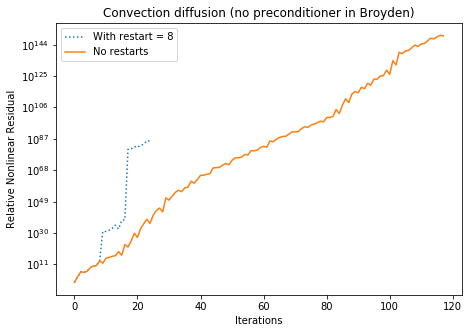

In [269]:
# Problem configuration

N = 31
h = 1.0 / (N + 1)
tol = h * h

x0 = np.zeros(N * N)

cdiff = ConvectionDiffusionOperator(N, exact = exact)

xar, itcvr, resvr = brsol(x0, cdiff, atol=tol, rtol=tol, nmax = 8)
xa, itcv, resv = brsol(x0, cdiff, atol=tol, rtol=tol, nmax = 3000)

plt.subplot(1, 2, 1)
plt.title('Convection diffusion (no preconditioner in Broyden)')
plt.plot(itcvr, resvr, linestyle=':', label = 'With restart = 8')
plt.plot(itcv, resv, label = 'No restarts')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative Nonlinear Residual')
plt.legend()
plt.show()

In [672]:
def JacobiApproximation(F, x, h):
    N = len(x)
    M = np.zeros((N, N))
    
    fx = F(x)
    # a[:,1] means all elements of column 1
    ejh = np.zeros(N)
    for j in range(N):
        if j != 0:
            ejh[j - 1] = 0.0
        ejh[j] = h
        
        if not np.any(x): #all zeros
            M[j, :] = (F(ejh) - fx) / h 
        else:
            nfx = np.linalg.norm(fx)
            M[j, :] = (F(x + ejh * nfx) - fx) / (h * nfx)
    
    return M.transpose()

def JacobiApproximationFastV(F, x, h, memsize = 10):
    N = len(x)
    
    fx = F(x)
    nfx = np.linalg.norm(fx)
    
    is_zeros = not np.any(x)
    if is_zeros:
        invh = 1.0 / h
    else:
        invh = 1.0 / (h * nfx)
    
    indptr  = np.zeros(N + 1, dtype=np.int32)
    indices = [] #np.zeros(N * memsize, dtype=np.int32)
    data    = [] #np.zeros(N * memsize, dtype=np.float64)
    k = 0
    
    indptr[0] = 0
    
    ejh = np.copy(x)
    if is_zeros:
        ejha = h
    else:
        ejha = h * nfx
    
    for j in range(N):
        
        if j != 0:
            ejh[j - 1] -= ejha

        ejh[j] += ejha
        
        row = (F(ejh) - fx) * invh
            
        nnz = np.nonzero(row)[0]
        indptr[j + 1] = indptr[j] + len(nnz)

        for i in range(k, k + len(nnz)):
            indices.append(nnz[i - k])
            data.append(row[nnz[i - k]])
            
        k = k + len(nnz)
    
    return csc_matrix((data, indices, indptr), shape=(N, N))

def ApplyJacobi(F, x, h):
    return JacobiApproximation(F, x, h).dot(x)

def ApplyJacobiFastV(F, x, h):
    return JacobiApproximationFastV(F, x, h).dot(x)

In [673]:
class PoissonPDEOperator(AbstractOperator):
    
    def __init__(self, N, exact = None):
        self.N    = N
        self.h    = 1.0 / (N + 1)
        self.ih2  = 1.0 / (self.h * self.h)
        self._rhs = np.ones(self.N)
        if exact is not None:
            tmp = np.empty(self.N)
            for i in range(self.N):
                tmp[i] = exact((i + 1) * self.h)
            self._rhs = self.matvec(tmp)
            self._exact = tmp
        
    def matvec(self, x):
        nx = np.zeros(self.N)
        for i in range(self.N):
            nx[i] = -self._uxx(x, i)
        return nx
    
    def rhs(self):
        return self._rhs
    
    def exact(self):
        return self._exact
    
    def __call__(self, x):
        return self.matvec(x) - self.rhs()
        
    def _uxx(self, x, i):
        uip1 = x[i + 1] if i < N - 1 else 0.0
        uim1 = x[i - 1] if i > 0 else 0.0
        return (uip1 - 2.0 * x[i] + uim1) * self.ih2
    

In [674]:
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import spilu
from scipy.sparse import csc_matrix
from math import sqrt

def newton(x, F, atol = 10e-6, rtol = 10e-6, M = None):
    xs = x
    
    n = len(x)
    
    #h = 1 / (n + 1)
    h = 10 ** -2
    nfx = np.linalg.norm(F(xs))
    rc = r0 = nfx / sqrt(n)
    
    while rc > rtol * r0 + atol:
        jacobim = csc_matrix(JacobiApproximationFastV(F, xs, h))
        ilu = spilu(jacobim)
        s = ilu.solve(-1.0 * F(xs))
        
#         jacobi = LinearOperator((n, n), lambda v: ApplyJacobiFastV(F, v, h))
#         rhs = -1.0 * F(xs)
#         s, info = gmres(jacobi, rhs, tol = 0.9, restart = 100000, M = M, callback = lambda m: print(m))
        ns = np.linalg.norm(s)
        if ns < 10e-10:
            print('ns < 10e-10')
            break
        xs = xs + s
        nfx = np.linalg.norm(F(xs))
        print('nfx = ' + str(nfx))
        if nfx <= rtol * r0 + atol:
            print('exit')
            break
        rc = nfx / sqrt(n)
        
        
    return xs

In [679]:
# Problem configuration

N = 31
h = 1.0 / (N + 1)
tol = h * h

x0 = np.zeros(N * N)

def pexact(x):
    return x * x

pde = PDE_2D_LinearOperator(N, exact = exact)
poisson = PoissonPDEOperator(N, exact = pexact)
heq = HEquationNonLinearOperator(c = 0.9)
cdiff = ConvectionDiffusionOperator(N, exact = exact)
fish2d = Fish2DLinearOperator(N)

#fish2dM = LinearOperator((N, N), lambda v: fish2d(v))

problem = lambda x: fish2d(pde(x))

xn = newton(x0, problem)

print(np.linalg.norm(pde(xn)))

nfx = 0.029689246527966347
nfx = 6.855508283945708e-05
0.06635090405869397


In [ ]:
xb, itcb, resb = brsol(x0, cdiff)

print(np.linalg.norm(cdiff(xb)))

In [454]:
xb, itcb, resb = brsol(x0, lambda x: fish2d(cdiff(x)))

print(np.linalg.norm(cdiff(xb)))

0.023300984536814773
